# Projekt Dno Oka
## Autorzy
### Jędrzej Warczyński 148234

## Dane
https://www5.cs.fau.de/research/data/fundus-images/

## Wykorzystywane biblioteki

In [1]:
import os
import cv2
import numpy as np
from skimage import filters, morphology
import matplotlib.pyplot as plt

## Wymaganie 3.0

In [3]:
# Ścieżki do folderów
images_folder = "data/images/"
manual_folder = "data/manual/"
mask_folder = "data/mask/"

file_names = os.listdir(images_folder)

In [4]:
def threshold_image(image, threshold):
    thresholded_image = np.where(image < threshold, 0, 255)
    return thresholded_image

In [5]:
def preprocess(image):
    _, green_chanel, _ = cv2.split(image)
    img = cv2.medianBlur(green_chanel, 7)

    clahe = cv2.createCLAHE(clipLimit=7.0, tileGridSize=(7, 7))
    img = clahe.apply(img)

    return img

In [6]:
def process_image(preprocessed_img):
    img = filters.frangi(preprocessed_img, gamma=0.8, beta=0.15)
    img = (img * 255).astype(np.uint8)
    return img

In [7]:
def post_process_image(processed_img):
    img = cv2.medianBlur(processed_img, 3)
    img = threshold_image(img, 35)
    img = np.array(img, bool)
    img = morphology.remove_small_objects(img, min_size=128)*255
    img = img.astype(np.uint8)
    
    kernel = np.ones((5, 5), np.uint8)
    img = cv2.morphologyEx(img, cv2.MORPH_OPEN, kernel)
    img = img.astype(np.uint8)

    return img

In [8]:
def applay_fov_mask(img, fov_mask):
    img = cv2.bitwise_and(img, img, mask=fov_mask.astype(np.uint8))
    return img

In [9]:
def segment_vessels(image, fov_mask):
    preprocessed_img = preprocess(image)
    processed_img = process_image(preprocessed_img)
    postprocessed_img = post_process_image(processed_img)
    segmentation_mask = applay_fov_mask(postprocessed_img, fov_mask)
    return segmentation_mask

In [10]:
def calculate_misclassified_mask(segmentation_mask, expert_mask):
    misclassified_mask = np.zeros((*segmentation_mask.shape, 3), dtype=np.uint8)
    misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask <= 128)] = [255, 0, 0]
    misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask > 128)] = [255, 255, 255]
    # misclassified_mask[np.logical_and(segmentation_mask > 128, expert_mask > 128)] = [0, 255, 0]
    misclassified_mask[np.logical_and(segmentation_mask < 128, expert_mask > 128)] = [0, 0, 255]
    return misclassified_mask

In [11]:
def calculate_metrics(expert_mask, generated_mask):
    TP = np.sum(np.logical_and(expert_mask == 255, generated_mask == 255))
    TN = np.sum(np.logical_and(expert_mask == 0, generated_mask == 0))
    FP = np.sum(np.logical_and(expert_mask == 0, generated_mask == 255))
    FN = np.sum(np.logical_and(expert_mask == 255, generated_mask == 0))

    accuracy = (TP + TN) / (TP + TN + FP + FN)
    sensitivity = TP / (TP + FN)
    specificity = TN / (TN + FP)

    return TP, TN, FP, FN, accuracy, sensitivity, specificity

In [12]:
for file_name in file_names[:1]:
    image_path = os.path.join(images_folder, file_name)
    image = cv2.imread(image_path)

    mask_path = os.path.join(manual_folder, file_name.split('.')[0] + '.tif')
    expert_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    fov_mask_path = os.path.join(mask_folder, file_name.split('.')[0] + '_mask.tif')
    fov_mask = cv2.imread(fov_mask_path, cv2.IMREAD_GRAYSCALE)

    segmentation_mask = segment_vessels(image, fov_mask)
    misclassification_mask = calculate_misclassified_mask(segmentation_mask, expert_mask)

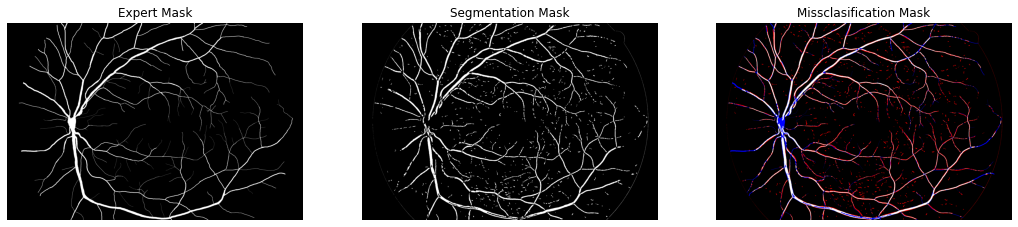

In [13]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.imshow(expert_mask, cmap='gray')
plt.title('Expert Mask')
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(segmentation_mask, cmap='gray')
plt.title('Segmentation Mask')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(misclassification_mask, cmap='gray')
plt.title('Missclasification Mask')
plt.axis('off')

plt.show()

Macierz pomyłek:
TP: 297081
TN: 7497760
FP: 271302
FN: 119201
Trafność (accuracy): 0.9522924143444674
Czułość (sensitivity): 0.7136532446754844
Swoistość (specificity): 0.9650791820170826


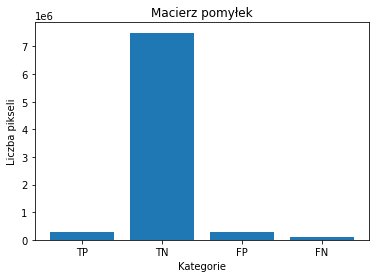

In [14]:
TP, TN, FP, FN, accuracy, sensitivity, specificity = calculate_metrics(expert_mask, segmentation_mask)

print("Macierz pomyłek:")
print("TP:", TP)
print("TN:", TN)
print("FP:", FP)
print("FN:", FN)

print("Trafność (accuracy):", accuracy)
print("Czułość (sensitivity):", sensitivity)
print("Swoistość (specificity):", specificity)

labels = ['TP', 'TN', 'FP', 'FN']
values = [TP, TN, FP, FN]

plt.figure(figsize=(6, 4))
plt.bar(labels, values)
plt.title('Macierz pomyłek')
plt.xlabel('Kategorie')
plt.ylabel('Liczba pikseli')
plt.show()
